ResNet50 model 

In [106]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import numpy as np 
import pandas as pd 

from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from PIL import Image
import torch
import torchvision
from torchvision.models.resnet import resnet50
import tqdm as notebook_tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    torch.cuda.empty_cache()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn 

In [4]:
device

device(type='cuda')

In [73]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

In [74]:
# defining hyperparameters  
epochs = 3   #the nn will train 29 times 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [75]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

In [105]:
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [76]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    base_dataset = datasets.ImageFolder(
        root='/volumes1/thesis/notebooks/data/gtsrb/GTSRB/Training', transform=transforms,
    )

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7fd58c1ece80>, <torch.utils.data.dataloader.DataLoader object at 0x7fd5b33d7640>)


In [77]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [78]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [79]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [80]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [81]:
# training function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [82]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048,43)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)

model = model.to(device)

In [83]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


21:32:31 --- Epoch: 0	Train loss: 2.5560	Valid loss: 1.5238	Train accuracy: 57.35	Valid accuracy: 53.55
21:32:47 --- Epoch: 1	Train loss: 0.9968	Valid loss: 0.6054	Train accuracy: 87.72	Valid accuracy: 82.09
21:33:03 --- Epoch: 2	Train loss: 0.3226	Valid loss: 0.3136	Train accuracy: 96.10	Valid accuracy: 90.52


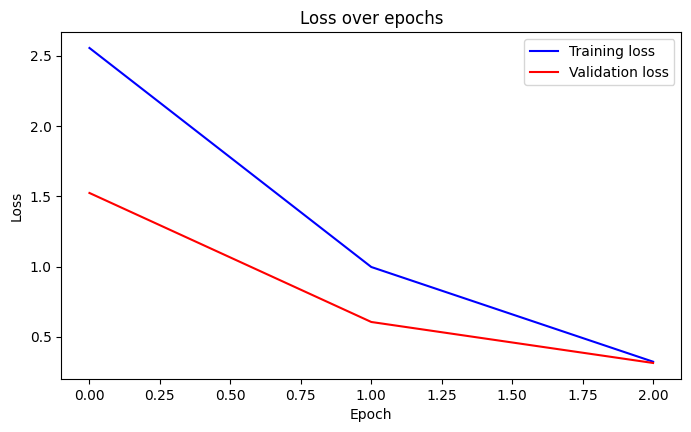

In [84]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

In [85]:
torch.save(model.state_dict(), "resnet50.pt")

# Adversarial attacks

In [86]:
# IFGSM

def ifgsm(model, x, y, device, epsilon=0.01, alpha=0.01, num_iter=10):
    """
    Generates adversarial examples using the IFGSM attack.

    Parameters:
    - model: A PyTorch model.
    - x: Input data, a tensor of shape (batch_size, input_dim).
    - y: Target labels, a tensor of shape (batch_size).
    - device: The device to use (either 'cpu' or 'cuda').
    - epsilon: The maximum perturbation.
    - alpha: The step size for the attack.
    - num_iter: The number of iterations for the attack.

    Returns:
    - A tensor of shape (batch_size, input_dim) containing the adversarial examples.
    """
    # Set the model to evaluation mode
    model.eval()

    # Move the data and labels to the device
    x, y = x.to(device), y.to(device)

    # Set the minimum and maximum values for the input data
    min_val, max_val = x.min(), x.max()

    # Set the perturbation to zero
    perturbation = torch.zeros_like(x, requires_grad=True)

    # Set the flag to False
    fooling = False

    # Loop over the number of iterations
    for _ in range(num_iter):
        # Forward pass
        logits = model(x + perturbation)

        # Get the prediction
        _, pred = logits.max(1)

        # Check if the prediction is different from the target label
        if not torch.eq(pred, y).all():
            fooling = True
            break


        # Calculate the loss
        loss = loss_fn(logits, y)

        # Backpropagate the gradients
        loss.backward()

        # Get the gradient of the perturbation
        grad = perturbation.grad.data

        # Calculate the sign of the gradient
        sign_grad = grad.sign()

        # Calculate the value to add to the perturbation
        with torch.no_grad():
            perturbation += alpha * sign_grad

        # Clamp the perturbation between the minimum and maximum values
        perturbation = torch.clamp(perturbation, min_val - x, max_val - x)

        # Zero the gradients
        model.zero_grad()
        # perturbation.grad.zero_()
        perturbation = torch.zeros_like(x, requires_grad=True)


    # Project the perturbation onto the l_infinity ball
    perturbation = epsilon * perturbation.sign()

    # Clamp the perturbation between the minimum and maximum values
    perturbation = torch.clamp(perturbation, min_val - x, max_val - x)

    # Set the model back to training mode
    model.train()

    # Return the adversarial examples
    return x + perturbation


In [98]:
# Set the model to evaluation mode
model.eval()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

# Set the number of epochs for adversarial training
num_epochs = 10

for epoch in range(num_epochs):
    # Loop over the training data
    for x, y in train_loader:
        # Move the data to the device
        x, y = x.to(device), y.to(device)

        # Create adversarial examples using IFGSM
        x_adv = ifgsm(model, x, y, device)
        # Calculate the loss
        loss = loss_fn(model(x_adv), y)
        # Backpropagate the gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
# Set the model back to training mode
fgsm_model = model.train()


In [102]:
fgsm_model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [108]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = fgsm_model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth
# constant for classes
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (40,15))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# print(cf_matrix)
# cf_report = classification_report(y_true, y_pred)
# print(cf_report)

In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))
print('Micro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))
print('Macro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))
print('Weighted Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='weighted')))


Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Micro Sensitivity: 0.94

Macro Precision: 0.91
Macro Recall: 0.90
Macro F1-score: 0.90

Macro Sensitivity: 0.90

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.94
Weighted Sensitivity: 0.94



In [99]:
ifgsm_accuracy = ifgsm(fgsm_model, x, y, device, epsilon=0.01, alpha=0.01, num_iter=10)

# CW 

In [103]:
# CW

def carlini_wagner(model, x, y, device, c=1, kappa=0, lr=0.01, num_iter=100):
    """
    Generates adversarial examples using the Carlini-Wagner attack.

    Parameters:
    - model: A PyTorch model.
    - x: Input data, a tensor of shape (batch_size, input_dim).
    - y: Target labels, a tensor of shape (batch_size).
    - device: The device to use (either 'cpu' or 'cuda').
    - c: The constant to use in the attack.
    - kappa: The confidence level to use in the attack.
    - lr: The learning rate for the attack.
    - num_iter: The number of iterations for the attack.

    Returns:
    - A tensor of shape (batch_size, input_dim) containing the adversarial examples.
    """
    # Set the model to evaluation mode
    model.eval()

    # Move the data and labels to the device
    x, y = x.to(device), y.to(device)

    # Set the minimum and maximum values for the input data
    min_val, max_val = x.min(), x.max()

    # Set the perturbation to zero
    perturbation = torch.zeros_like(x, requires_grad=True)

    # Set the loss function
    loss_fn = nn.CrossEntropyLoss(reduction='none')

    # Set the optimizer
    optimizer = optim.Adam([perturbation], lr=lr)

    # Set the confidence to be the maximum value of the logits
    confidence = torch.max(model(x)).detach() * kappa

    # Loop over the number of iterations
    for _ in range(num_iter):
        # Forward pass
        logits = model(x + perturbation)

        # Calculate the loss
        loss = (loss_fn(logits, y.clone()) - confidence).clamp(min=0)

        # Backpropagate the gradients
        loss.sum().backward(retain_graph=True)

        # Update the perturbation
        optimizer.step()

        # Project the perturbation onto the l_infinity ball
        perturbation.data.renorm_(2, 0, c)

        # Clamp the perturbation between the minimum and maximum values
        perturbation = torch.clamp(perturbation, min_val - x, max_val - x)

        # Zero the gradients
        optimizer.zero_grad()

    # Set the model back to training mode
    model.train()

    # Return the adversarial examples
    return x + perturbation


In [94]:
# deepfool 
def deepfool(model, x, y, device):
    """
    Generates adversarial examples using the DeepFool attack.

    Parameters:
    - model: A PyTorch model.
    - x: Input data, a tensor of shape (batch_size, input_dim).
    - y: Target labels, a tensor of shape (batch_size).
    - device: The device to use (either 'cpu' or 'cuda').

    Returns:
    - A tensor of shape (batch_size, input_dim) containing the adversarial examples.
    """
    # Set the model to evaluation mode
    model.eval()

    # Move the data and labels to the device
    x, y = x.to(device), y.to(device)

    # Set the minimum and maximum values for the input data
    min_val, max_val = x.min(), x.max()

    # Set the perturbation to zero
    perturbation = torch.zeros_like(x, requires_grad=True)

    # Set the flag to False
    fooling = False

    # Set the maximum number of iterations
    max_iter = 100

    # Set the overshoot to 0.02
    overshoot = 0.02

    # Set the iteration to 0
    itr = 0

    # Set the loss function
    loss_fn = nn.CrossEntropyLoss(reduction='none')

    while not fooling:
        # Increment the iteration counter
        itr += 1

        # Forward pass
        logits = model(x + perturbation)

        # Get the prediction
        _, pred = logits.max(1)

        # Check if the prediction is different from the target label
        if not torch.eq(pred, y).all():
            fooling = True
            break


        if itr >= max_iter:
            break

        # Calculate the loss
        loss = loss_fn(logits, y)
        
        # Backpropagate the gradients
        loss.sum().backward()

        # Get the gradient of the perturbation
        grad = perturbation.grad.data

        # Calculate the sign of the gradient
        sign_grad = grad.sign()
        # sign_grad = sign_grad.view(-1, dim)

        # Calculate the norm of the gradient
        grad_norm = grad.view(grad.shape[0], -1).norm(dim=1)
        # perturbation += overshoot * sign_grad / grad_norm(-1,1)

        # Calculate the value to add to the perturbation
        with torch.no_grad():
            perturbation += overshoot * sign_grad / grad_norm.view(-1, 1)

        # Clamp the perturbation between the minimum and maximum values
        perturbation = torch.clamp(perturbation, min_val - x, max_val - x)

        # Zero the gradients
        model.zero_grad()
        perturbation.grad.zero_()

    # Set the model back to training mode
    model.train()

    # Return the adversarial examples
    return x + perturbation


# Adversarial training 

# evaluation 

In [16]:
parameters = (sum(p.numel() for p in model.parameters()))
parameters

11689512

In [17]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

11689512

In [18]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn 

In [20]:
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [21]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classes
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (40,15))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# print(cf_matrix)
# cf_report = classification_report(y_true, y_pred)
# print(cf_report)

In [25]:
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report


get_classification_report(y_test = y_true, y_pred = y_pred)

,precision,recall,f1-score,support
13,0.973865,0.983333,0.978576,720.000000
12,0.976155,0.949275,0.962528,690.000000
10,0.935578,0.968182,0.951601,660.000000
35,0.964384,0.902564,0.932450,390.000000
37,0.918033,0.933333,0.925620,60.000000
9,0.937768,0.910417,0.923890,480.000000
33,0.907834,0.938095,0.922717,210.000000
17,0.938416,0.888889,0.912981,360.000000
16,0.969466,0.846667,0.903915,150.000000
15,0.947644,0.861905,0.902743,210.000000


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))
print('Micro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))
print('Macro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))
print('Weighted Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='weighted')))


Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82

Micro Sensitivity: 0.82

Macro Precision: 0.78
Macro Recall: 0.75
Macro F1-score: 0.76

Macro Sensitivity: 0.75

Weighted Precision: 0.83
Weighted Recall: 0.82
Weighted F1-score: 0.82
Weighted Sensitivity: 0.82



In [31]:
cf_report(y_true, y_pred, zero_division = 0, target_names=['0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons'])
print(cf_report)

NameError: name 'cf_report' is not defined

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
print(cf_matrix)

[[ 27  26   0 ...   0   0   0]
 [  8 608  74 ...   0   0   0]
 [  2  22 653 ...   0   0   2]
 ...
 [  0   0   0 ...  69   0   0]
 [  0   0   0 ...   0  31   4]
 [  0   0   0 ...   0  33  54]]


In [ ]:
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('Resnet50.png')

In [29]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    classes = []
    plotMat = []

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred) 
